In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect = True)

In [6]:
#Base.classes.keys()

In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Create a session
session= Session(engine)

In [9]:
from sqlalchemy import inspect
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [10]:
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Find the most recent date in the data set.
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print("Last date in data set:", latest_date[0])

# Calculate the date one year from the last date in data set.
query_date = dt.date(2017,8,23)-dt.timedelta(days = 365)
print("Date one year from the last date:", query_date)

Last date in data set: 2017-08-23
Date one year from the last date: 2016-08-23


In [13]:
# Perform a query to retrieve the data and precipitation scores
measurement_columns = (Measurement.date, Measurement.prcp)
prcp_scores_data = session.query(*measurement_columns).\
filter(Measurement.date>=query_date).all()

prcp_scores_data[:10]

[('2016-08-23', 0.0),
 ('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.01),
 ('2016-08-29', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-31', 0.13),
 ('2016-09-01', 0.0)]

In [56]:
# Save the query results as a Pandas DataFrame 
prcp_scores_df = pd.DataFrame(prcp_scores_data, columns=["Date", "Precipitation"])

# Sort the dataframe by date
prcp_df = prcp_scores_df.sort_values(by="Date", ascending =True).dropna()

#Set the index to the date column
prcp_df.set_index("Date", inplace =True)
prcp_df.head(10)

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
2016-08-23,0.70
2016-08-23,0.02
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28


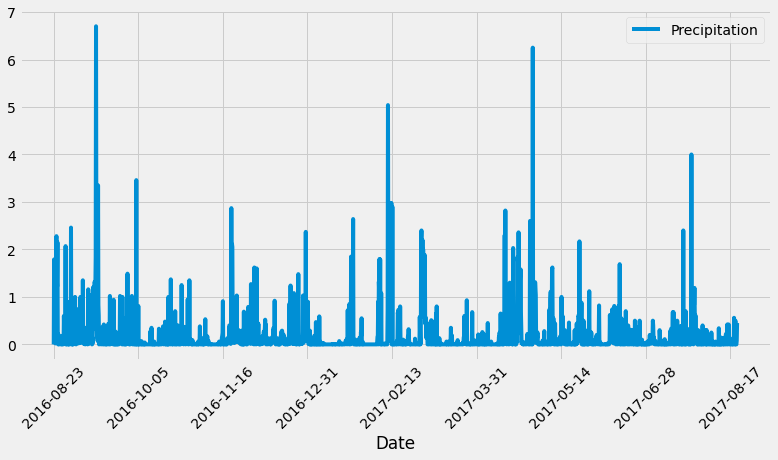

In [57]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(rot = 45, figsize = (12,6))
plt.savefig("Images/fig01.prcp_analysis.png")
plt.show()

In [58]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [59]:
# Design a query to calculate the total number stations in the dataset
count_stations = session.query(Station.id).count()
print("Total station number:", count_stations)

Total station number: 9


In [60]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
sel = [Measurement.station, func.count(Measurement.id)]
active_station = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()
active_station[:5]

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612)]

In [61]:
most_active_station = active_station[0][0]
print("The most active station : ", most_active_station)

The most active station :  USC00519281


In [62]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature recorded
lowest_highest_average = session.query(Measurement.station,  func.min(Measurement.tobs), 
                                      func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                                      filter(Measurement.station == most_active_station).\
                                      group_by(Measurement.station).all()

# print(lowest_highest_average)
print("-"*40)
print("Lowest temperature:", lowest_highest_average[0][1])
print("-"*40)
print("Highest temperature:", lowest_highest_average[0][2])
print("-"*40)
print("Average temperature:", lowest_highest_average[0][3])
print("-"*40)

----------------------------------------
Lowest temperature: 54.0
----------------------------------------
Highest temperature: 85.0
----------------------------------------
Average temperature: 71.66378066378067
----------------------------------------


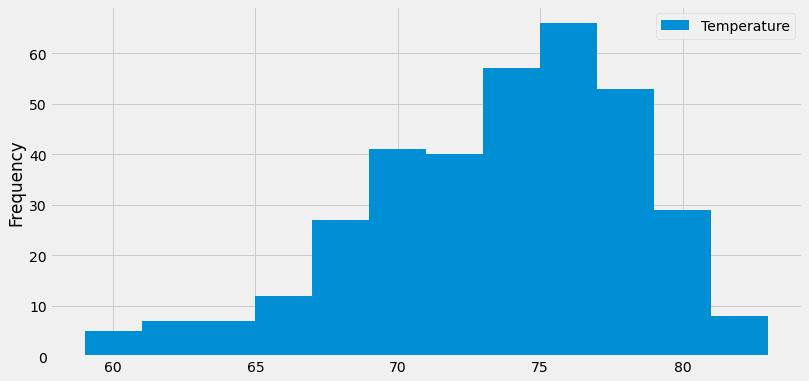

In [64]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query_result = session.query(Measurement.date, Measurement.tobs).\
                filter(Measurement.station == most_active_station).\
                filter(func.strftime("%Y-%m-%d", Measurement.date)>= query_date).all()

result_df = pd.DataFrame(query_result, columns= ["Date", "Temperature"])
result_df.plot.hist(bins=12, figsize=(12,6))
plt.savefig("Images/fig02.temp_analysis.png")


In [ ]:
# Close Session
session.close()